In [1]:
import os
import cv2
import gdown
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.measure import label, regionprops

### Run-Length Encoding (RLE)

In [2]:
def rle_encode(img):
    """
    Encode a binary mask represented as a 2D numpy array using Run-Length Encoding (RLE).

    Parameters:
    - img (numpy.ndarray): A 2D binary array representing the mask.

    Returns:
    - str: The RLE-encoded string representing the binary mask.
    """

    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decode a Run-Length Encoded (RLE) binary mask into a 2D numpy array.

    Parameters:
    - mask_rle (str): The RLE-encoded string representing the binary mask.
    - shape (tuple, optional): The shape of the target 2D array. Default is (768, 768).

    Returns:
    - numpy.ndarray: A 2D binary array representing the decoded mask.
    """

    if type(mask_rle) != str:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T  # Needed to align to RLE direction

# Load model

In [3]:
# Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-5):
    """
    Compute the Dice coefficient between two binary arrays.

    Parameters:
    - y_true (tensor): Ground truth binary tensor.
    - y_pred (tensor): Predicted binary tensor.
    - smooth (float): Smoothing factor to avoid division by zero.

    Returns:
    - float: Dice coefficient.
    """

    # Compute the intersection of y_true and y_pred by element-wise multiplication
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)

    # Compute the Dice coefficient
    dice_coeff = (2. * intersection + smooth) / (K.sum(K.square(y_true), -1) + K.sum(K.square(y_pred), -1) + smooth)

    return dice_coeff


# Load the model with custom_objects parameter
def load_model(model_url, model_path):
    """
    Loads a model from a given URL and saves it to a specified output path.

    Parameters:
    - url (str): The URL from which the model should be downloaded.
    - model_path (str): The path where the downloaded model should be saved.

    Returns:
    - keras.models.Model: The loaded Keras model.
    """
    # If the output path doesn't exist, download the model from the URL and save it to the output path
    if not os.path.exists(model_path):
        gdown.download(model_url, model_path, quiet=True, fuzzy=True)

    # Register the custom loss function and load model
    keras.losses.Dice = dice_coefficient
    keras.utils.get_custom_objects()['dice_coefficient'] = dice_coefficient
    loaded_model = keras.models.load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient})

    return loaded_model


model = load_model('https://drive.google.com/uc?export=download&id=1eyKPgbBQ0bY4d5DIX1aW_Y2auoEP1SJr', '../models/model_v1.h5')
model

# Visualize predictions

In [4]:
img = os.listdir("../data/images")

# Load and preprocess the input image
def preprocess_input(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
    if image.shape[0] == 0 or image.shape[1] == 0:
        print("Error: Loaded image has invalid dimensions.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize pixel values to the range [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

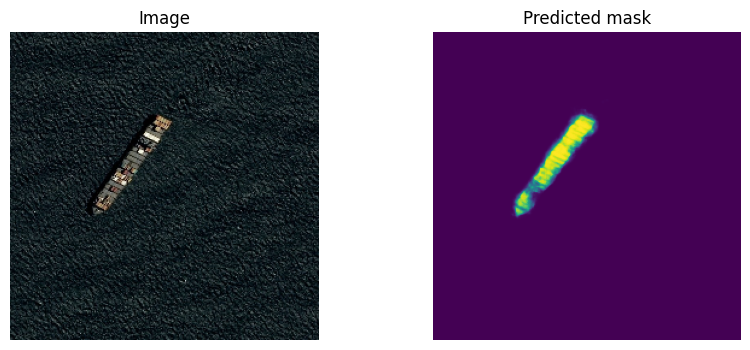

In [5]:
image = preprocess_input("../data/images/" + img[4])
output_mask = model.predict(image, verbose=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image, axis=0));
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(output_mask, axis=0));
plt.title('Predicted mask')
plt.axis('off')

plt.show();

# Save predicted masks

In [6]:
# Save predicted masks for images in a folder
def save_predicted_masks(images_folder, masks_folder, model):
    """
    Predict masks for images in the given folder using the provided model and save the masks.

    Parameters:
    - images_folder (str): Path to the folder containing input images.
    - masks_folder (str): Path to the folder where predicted masks will be saved.
    - model (keras.models.Model): The trained Keras model used for prediction.
    """
    # Create the output folder if it doesn't exist
    if not os.path.exists(masks_folder):
        os.makedirs(masks_folder)
    
    # List all image files in the input folder
    images = os.listdir(images_folder)
    
    # Iterate over each image file
    for img_name in images:
        # Preprocess the input image
        img_path = os.path.join(images_folder, img_name)
        image = preprocess_input(img_path)
        
        # Predict the mask for the image
        output_mask = model.predict(image, verbose=0)
        
        # Convert the output mask to an image format supported by OpenCV
        output_mask = np.squeeze(output_mask)
        output_mask = (output_mask > 0.3).astype(int)
        output_mask = (output_mask * 255).astype(np.uint8)
        
        # Save the output mask
        output_mask_path = os.path.join(masks_folder, img_name)
        cv2.imwrite(output_mask_path, output_mask)

        
save_predicted_masks('../data/images', '../data/predicted_masks', model)

# Make submission

In [7]:
def make_submission(folder_path, model):
    list_of_images = os.listdir(folder_path)
    image_id = []
    encoded_pixels = []
    
    for img_name in list_of_images:
        # Obtaining the model prediction.
        img = preprocess_input(os.path.join(folder_path, img_name))
        mask = model.predict(img, verbose=0)
        mask = np.squeeze(mask, axis=(0, 3))
        mask = cv2.resize(mask, (768, 768))
        mask = (mask > 0.3).astype(int)
        
        if np.all(mask == 0):
            image_id.append(img_name)
            encoded_pixels.append('')
        else:
            # Apply morphological operation to distinguish individual objects
            labeled_mask = label(mask)
            for region in regionprops(labeled_mask):
                # Create a mask for the current object
                single_ship_mask = (labeled_mask == region.label).astype(np.uint8)

                # Obtain RLE for the mask
                rle = rle_encode(single_ship_mask)

                # Add values to the lists
                image_id.append(img_name)
                encoded_pixels.append(rle)
    
    # Create a DataFrame
    df = pd.DataFrame({"ImageId": image_id, "EncodedPixels": encoded_pixels})
    return df

In [8]:
folder_path = '../data/images'
submission = make_submission(folder_path, model)
submission

,ImageId,EncodedPixels
0,000155de5.jpg,283115 1 283878 8 284644 11 285410 14 286177 1...
1,000155de5.jpg,346850 4
2,0002d0f32.jpg,
3,000532683.jpg,458960 11 459727 13 460494 15 461261 16 462029...
4,0005d01c8.jpg,368947 6 369714 9 370480 12 371247 13 372013 1...
5,0005d01c8.jpg,142711 4 143478 8 144245 11 145012 12 145779 1...
6,0005d01c8.jpg,65231 4 65998 6 66766 7 67534 8 68302 11 69070...
7,0006c52e8.jpg,156341 5 157107 12 157862 5 157875 15 158629 9...
8,000913daf.jpg,
9,001bcf222.jpg,228449 1 229217 1


In [9]:
img_name = '021e2b4dd.jpg'
one_sample_masks = submission[submission.ImageId == img_name]
one_sample_masks

,ImageId,EncodedPixels
11,021e2b4dd.jpg,80669 6 81431 16 82194 23 82960 28 83727 31 84...
12,021e2b4dd.jpg,419480 8 420245 17 421011 25 421778 31 422545 ...
13,021e2b4dd.jpg,94267 2 95034 5 95801 9 96568 11 97336 13 9810...


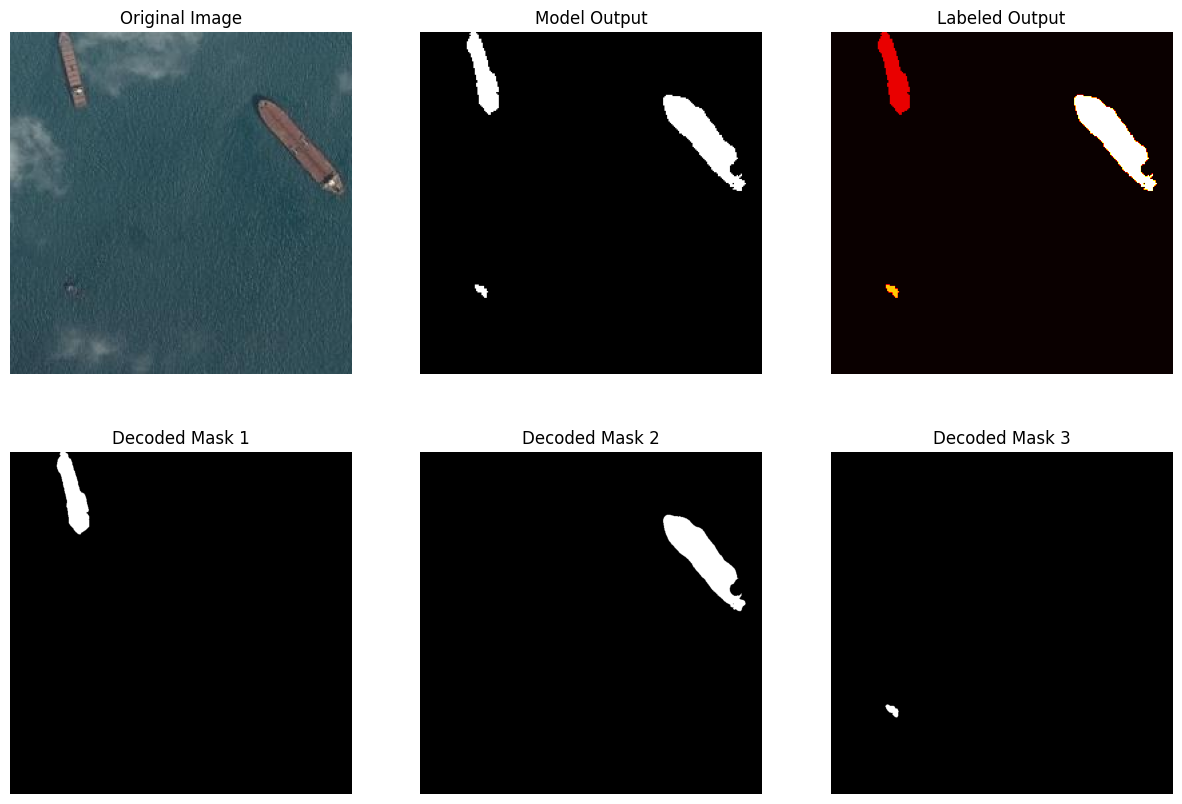

In [10]:
img_path = os.path.join(folder_path, img_name)
img = np.squeeze(preprocess_input(img_path), axis=0)
mask = model.predict(preprocess_input(img_path), verbose=0)
mask = (mask > 0.3).astype(int)

# Set the figure size
plt.figure(figsize=(15, 10))  # Adjust the width and height as needed

# Row 1
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.squeeze(mask, axis=0), cmap='gray')
plt.title('Model Output')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(label(np.squeeze(mask, axis=0)), cmap='hot')
plt.title('Labeled Output')
plt.axis('off')

# Row 2
plt.subplot(2, 3, 4)
plt.imshow(rle_decode(one_sample_masks.EncodedPixels.iloc[0]), cmap='gray')
plt.title('Decoded Mask 1')
plt.axis('off') 

plt.subplot(2, 3, 5)
plt.imshow(rle_decode(one_sample_masks.EncodedPixels.iloc[1]), cmap='gray')
plt.title('Decoded Mask 2')
plt.axis('off') 

plt.subplot(2, 3, 6)
plt.imshow(rle_decode(one_sample_masks.EncodedPixels.iloc[2]), cmap='gray')
plt.title('Decoded Mask 3')
plt.axis('off') 

# Show and save the plot
plt.savefig('../reports/visualizations/segmentations_masks.png', bbox_inches='tight')
plt.show()